In [1]:
%pylab inline
%config InlineBackend.figure_format = 'retina'

Populating the interactive namespace from numpy and matplotlib


In [2]:
from astropy.table import Table
from exoplanet.gp import terms, GP
import exoplanet as xo
import pandas as pd
import pymc3 as pm
import scipy.stats as ss
import seaborn as sns
import theano
import theano.tensor as tt
from tqdm import tqdm
import warnings

sns.set_context('notebook')
sns.set_style('ticks')
sns.set_palette('colorblind')

theano.config.gcc.cxxflags = "-Wno-c++11-narrowing"

In [3]:
visit = Table.read('../apogee/allVisit-v603.fits').to_pandas()
stars = Table.read('../apogee/allStar-v603.fits', hdu=1)

names = [name for name in stars.colnames if len(stars[name].shape) <= 1]
stars = stars[names].to_pandas()

In [4]:
joint = pd.merge(visit, stars, on='APOGEE_ID')
joint.sort_values(['APOGEE_ID', 'JD']);

In [5]:
rgs = joint[(joint['LOGG'] < 2) & (joint['LOGG'] > -1000)]

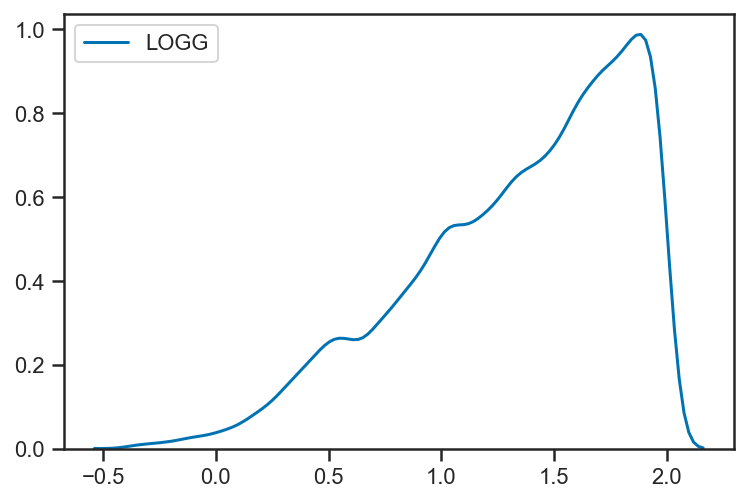

In [6]:
sns.kdeplot(rgs['LOGG'])

In [7]:
def count_num_5d(ts):
    dt = diff(sort(ts))
    
    return count_nonzero((dt < 5) & (dt > 0))

by_aid = rgs.groupby('APOGEE_ID')
num_5d_visits = by_aid.agg({'JD': count_num_5d})

In [8]:
i = 0
aid = num_5d_visits.sort_values(by='JD', ascending=False).index[i]
d = by_aid.get_group(aid)
d.sort_values(by='JD');

b'2M21330683+1209406' has log(g) = 0.39


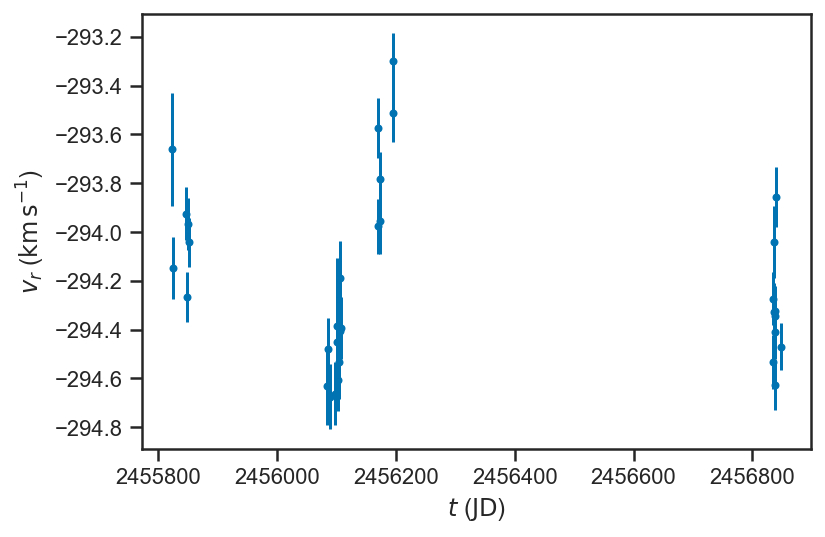

In [9]:
errorbar(d['JD'], d['VHELIO'], d['VRELERR'], fmt='.')

xlabel(r"$t$ ($\mathrm{JD}$)")
ylabel(r"$v_r$ ($\mathrm{km} \, \mathrm{s}^{-1}$)")

print('{:s} has log(g) = {:.2f}'.format(str(d['APOGEE_ID'].iloc[0]), d['LOGG'].iloc[0]))

In [10]:
teff_solar = 5777.0
logg_solar = 4.4374

numax_solar = 3090.0*1e-6*3600.0*24.0
nugran_solar = 30*1e-6*3600.0*24.0

numax_est = numax_solar*10**(d['LOGG']-logg_solar)*sqrt(d['TEFF']/teff_solar)
nugran_est = nugran_solar * (numax_est/numax_solar)**0.89

numax_est = numax_est.iloc[0]
nugran_est = nugran_est.iloc[0]

print('Estimated nu_max = {:.2g} / d, nu_gran = {:.2g} / d'.format(numax_est, nugran_est))

Estimated nu_max = 0.021 / d, nu_gran = 0.00056 / d


In [11]:
m = mean(d['VHELIO'])
s = std(d['VHELIO'])

d = d.sort_values(by='JD', ascending=True)
d = d[~(isnan(d['JD'])) & ~(isnan(d['VHELIO'])) & ~(isnan(d['VRELERR']))]

w0_est = 2*pi*numax_est
S0_est = s*s / (w0_est*2)

with pm.Model() as model:
    mu = pm.Normal('mu', mu=m, sigma=10*s, testval=m)
    
    log_c = pm.Normal('log_c', mu=log(nugran_est), sigma=log(3), testval=log(nugran_est))
    log_a = pm.Normal('log_a', mu=2.0*log(s/sqrt(2)), sigma=2.0*log(3), testval=2.0*log(s/sqrt(2)))
    
    log_S0 = pm.Normal('log_S0', mu=log(S0_est), sigma=2.0*log(3), testval=log(S0_est))
    log_w0 = pm.Normal('log_w0', mu=log(w0_est), sigma=log(3), testval=log(w0_est))
    log_Q = pm.Normal('log_Q', mu=log(2), sigma=log(3), testval=log(2))
    
    var_exp = pm.Deterministic('var_exp', tt.exp(log_c))
    var_SHO = pm.Deterministic('var_SHO', tt.exp(log_S0 + log_w0 + log_Q))
    _ = pm.Deterministic('var', var_exp+var_SHO)
    _ = pm.Deterministic('w0', tt.exp(log_w0))
    _ = pm.Deterministic('Q', tt.exp(log_Q))
    
    kernel = terms.RealTerm(log_c=log_c, log_a=log_a)
    kernel += terms.SHOTerm(log_S0=log_S0, log_w0=log_w0, log_Q=log_Q)
    gp = GP(kernel, d['JD'].to_numpy(), (d['VRELERR']*d['VRELERR']).to_numpy().astype(np.float64), mean=mu, J=3)
    
    gp.marginal('gp', observed=d['VHELIO'].to_numpy().astype(np.float64))

In [12]:
with model:
    trace = pm.sample(tune=1000, draws=1000, cores=4, chains=4, step=xo.get_dense_nuts_step())

Multiprocess sampling (4 chains in 4 jobs)
NUTS: [log_Q, log_w0, log_S0, log_a, log_c, mu]
Sampling 4 chains, 1 divergences: 100%|██████████| 8000/8000 [00:29<00:00, 275.11draws/s]
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.


In [13]:
pm.summary(trace)

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
mu,-294.113,0.768,-295.773,-292.880,0.026,0.019,856.0,856.0,1375.0,669.0,1.01
log_c,-7.080,1.192,-9.241,-4.830,0.034,0.024,1251.0,1251.0,1266.0,1936.0,1.00
log_a,-1.804,2.106,-5.851,1.737,0.091,0.065,533.0,533.0,531.0,1137.0,1.01
log_S0,-0.372,2.145,-4.911,2.941,0.082,0.058,685.0,685.0,837.0,1284.0,1.00
log_w0,-3.095,1.124,-4.855,-0.685,0.051,0.036,494.0,494.0,861.0,474.0,1.01
log_Q,0.524,1.119,-1.792,2.488,0.035,0.031,995.0,650.0,1012.0,698.0,1.01
var_exp,0.002,0.003,0.000,0.006,0.000,0.000,1505.0,1505.0,1266.0,1936.0,1.00
var_SHO,0.139,0.325,0.000,0.396,0.008,0.005,1833.0,1833.0,926.0,1230.0,1.00
var,0.141,0.325,0.000,0.399,0.008,0.005,1834.0,1834.0,873.0,1034.0,1.00
w0,0.129,0.387,0.004,0.419,0.017,0.012,508.0,508.0,861.0,474.0,1.01


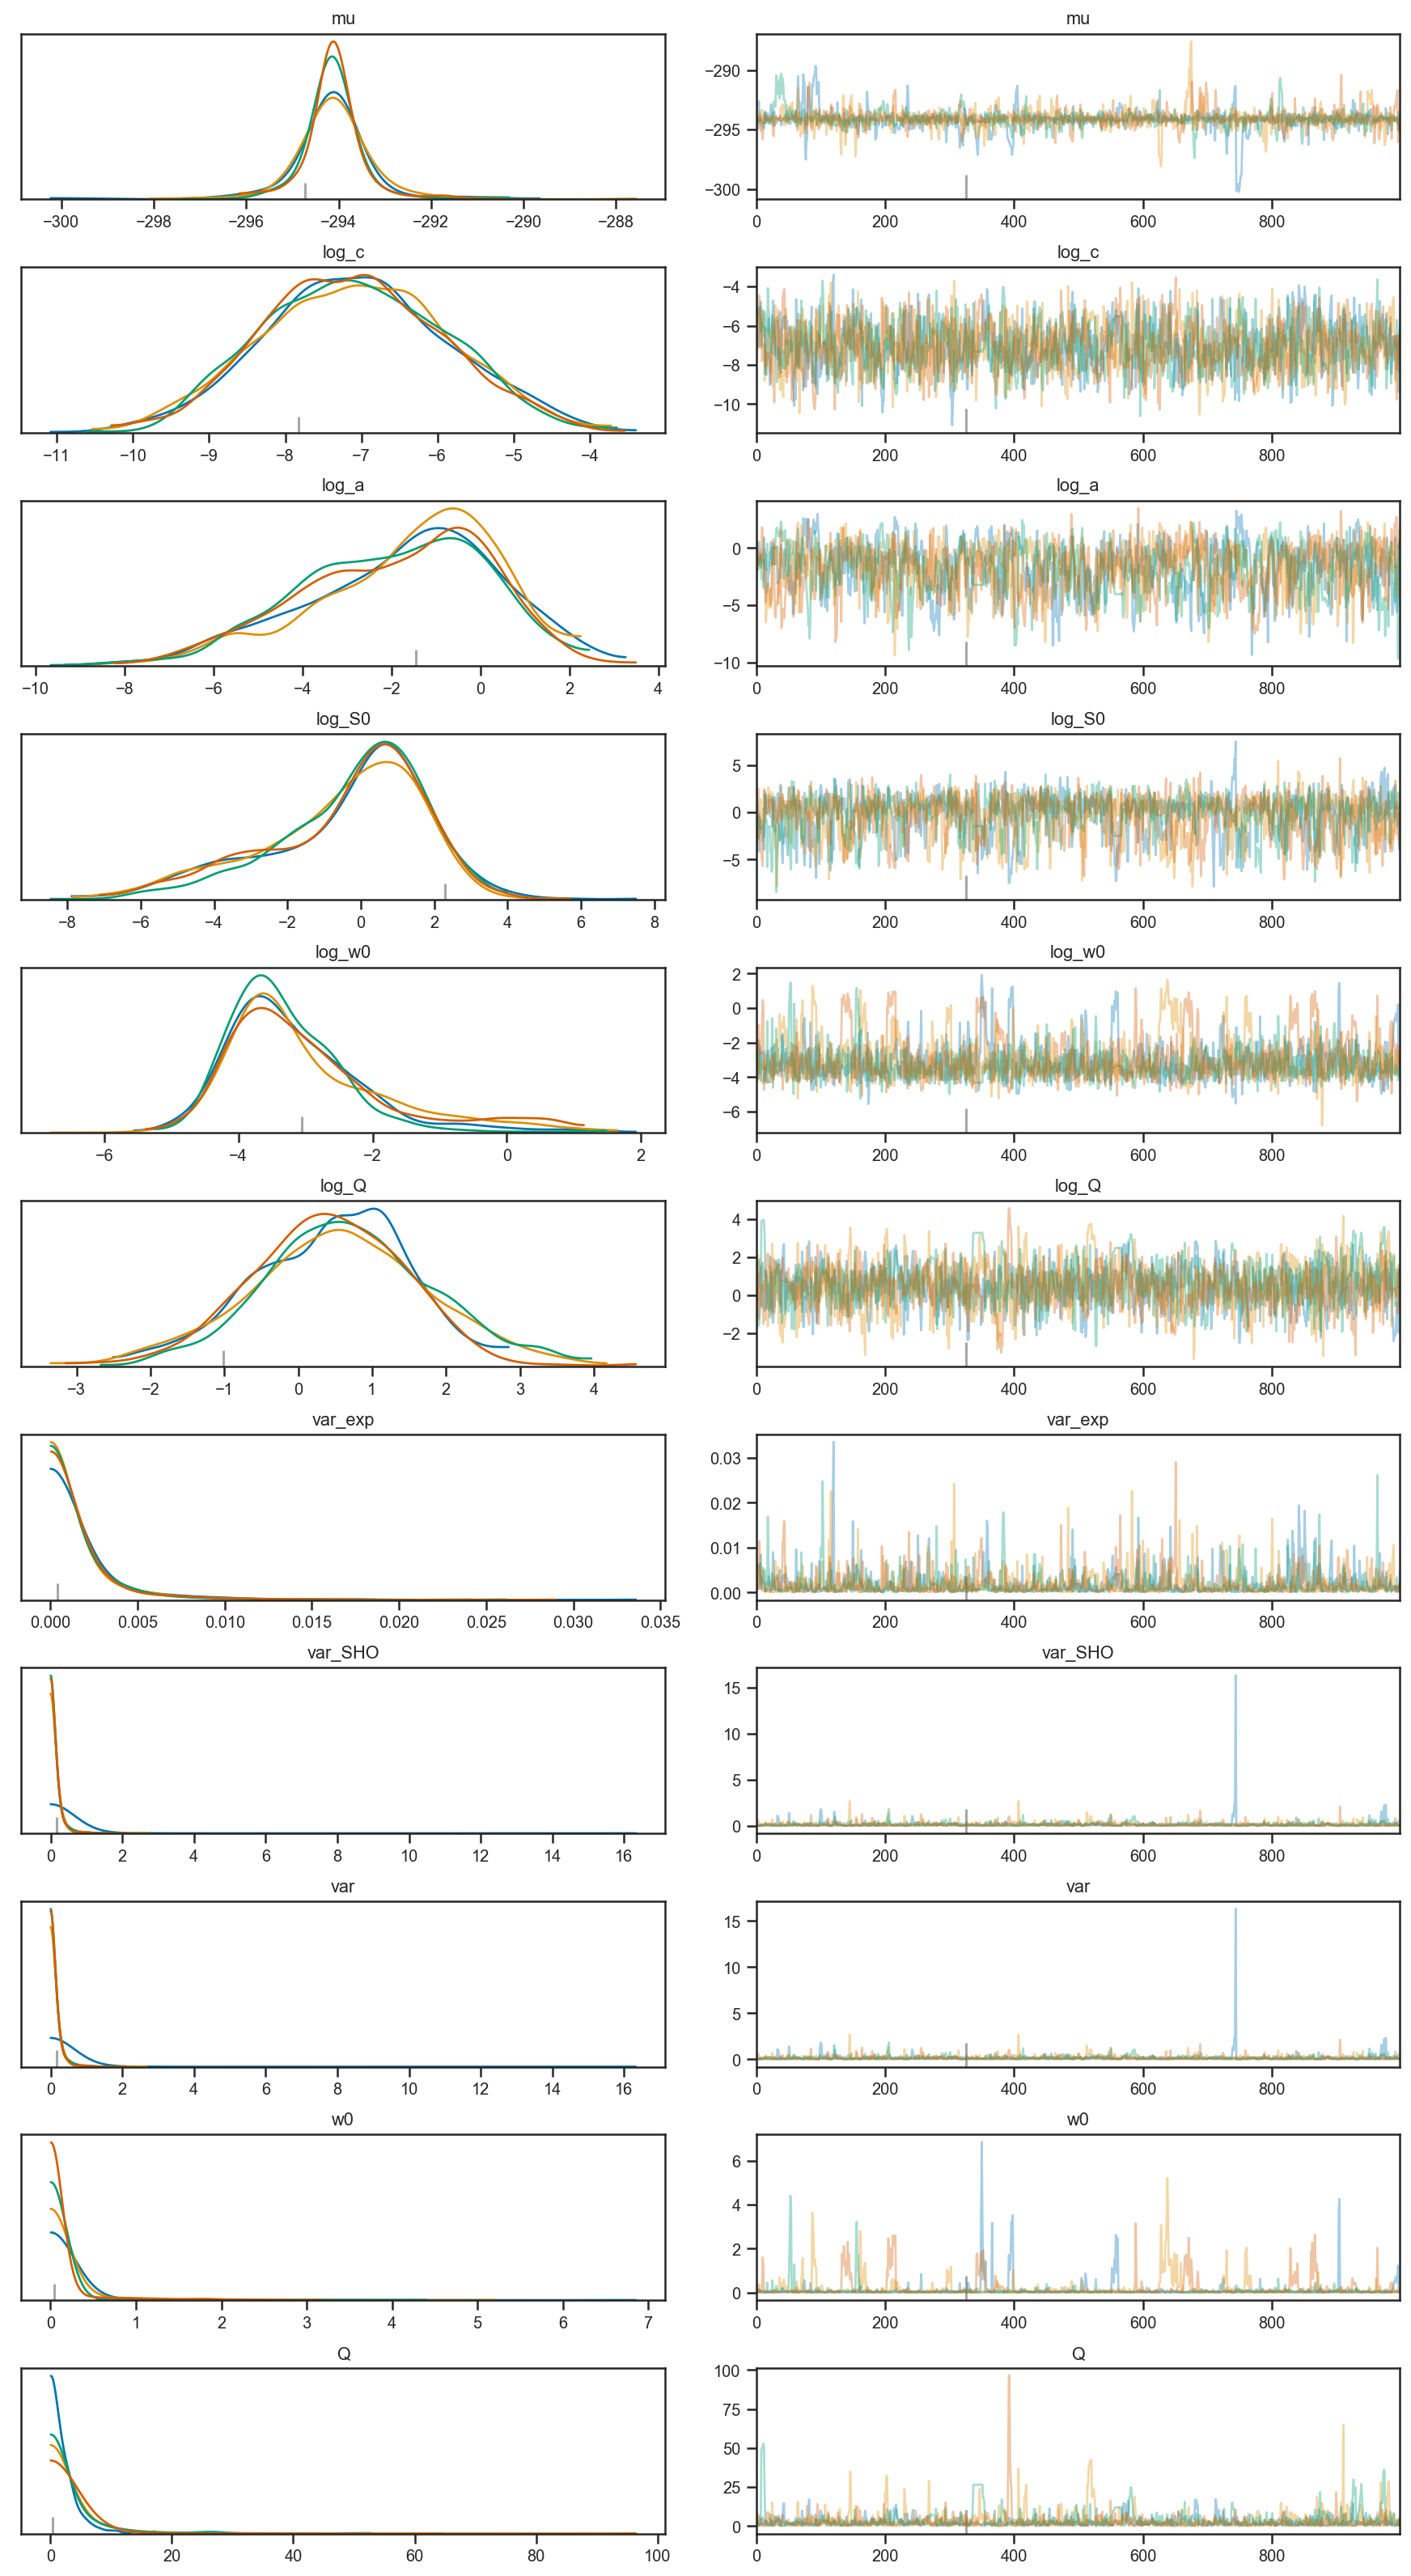

In [14]:
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    pm.plot_trace(trace)

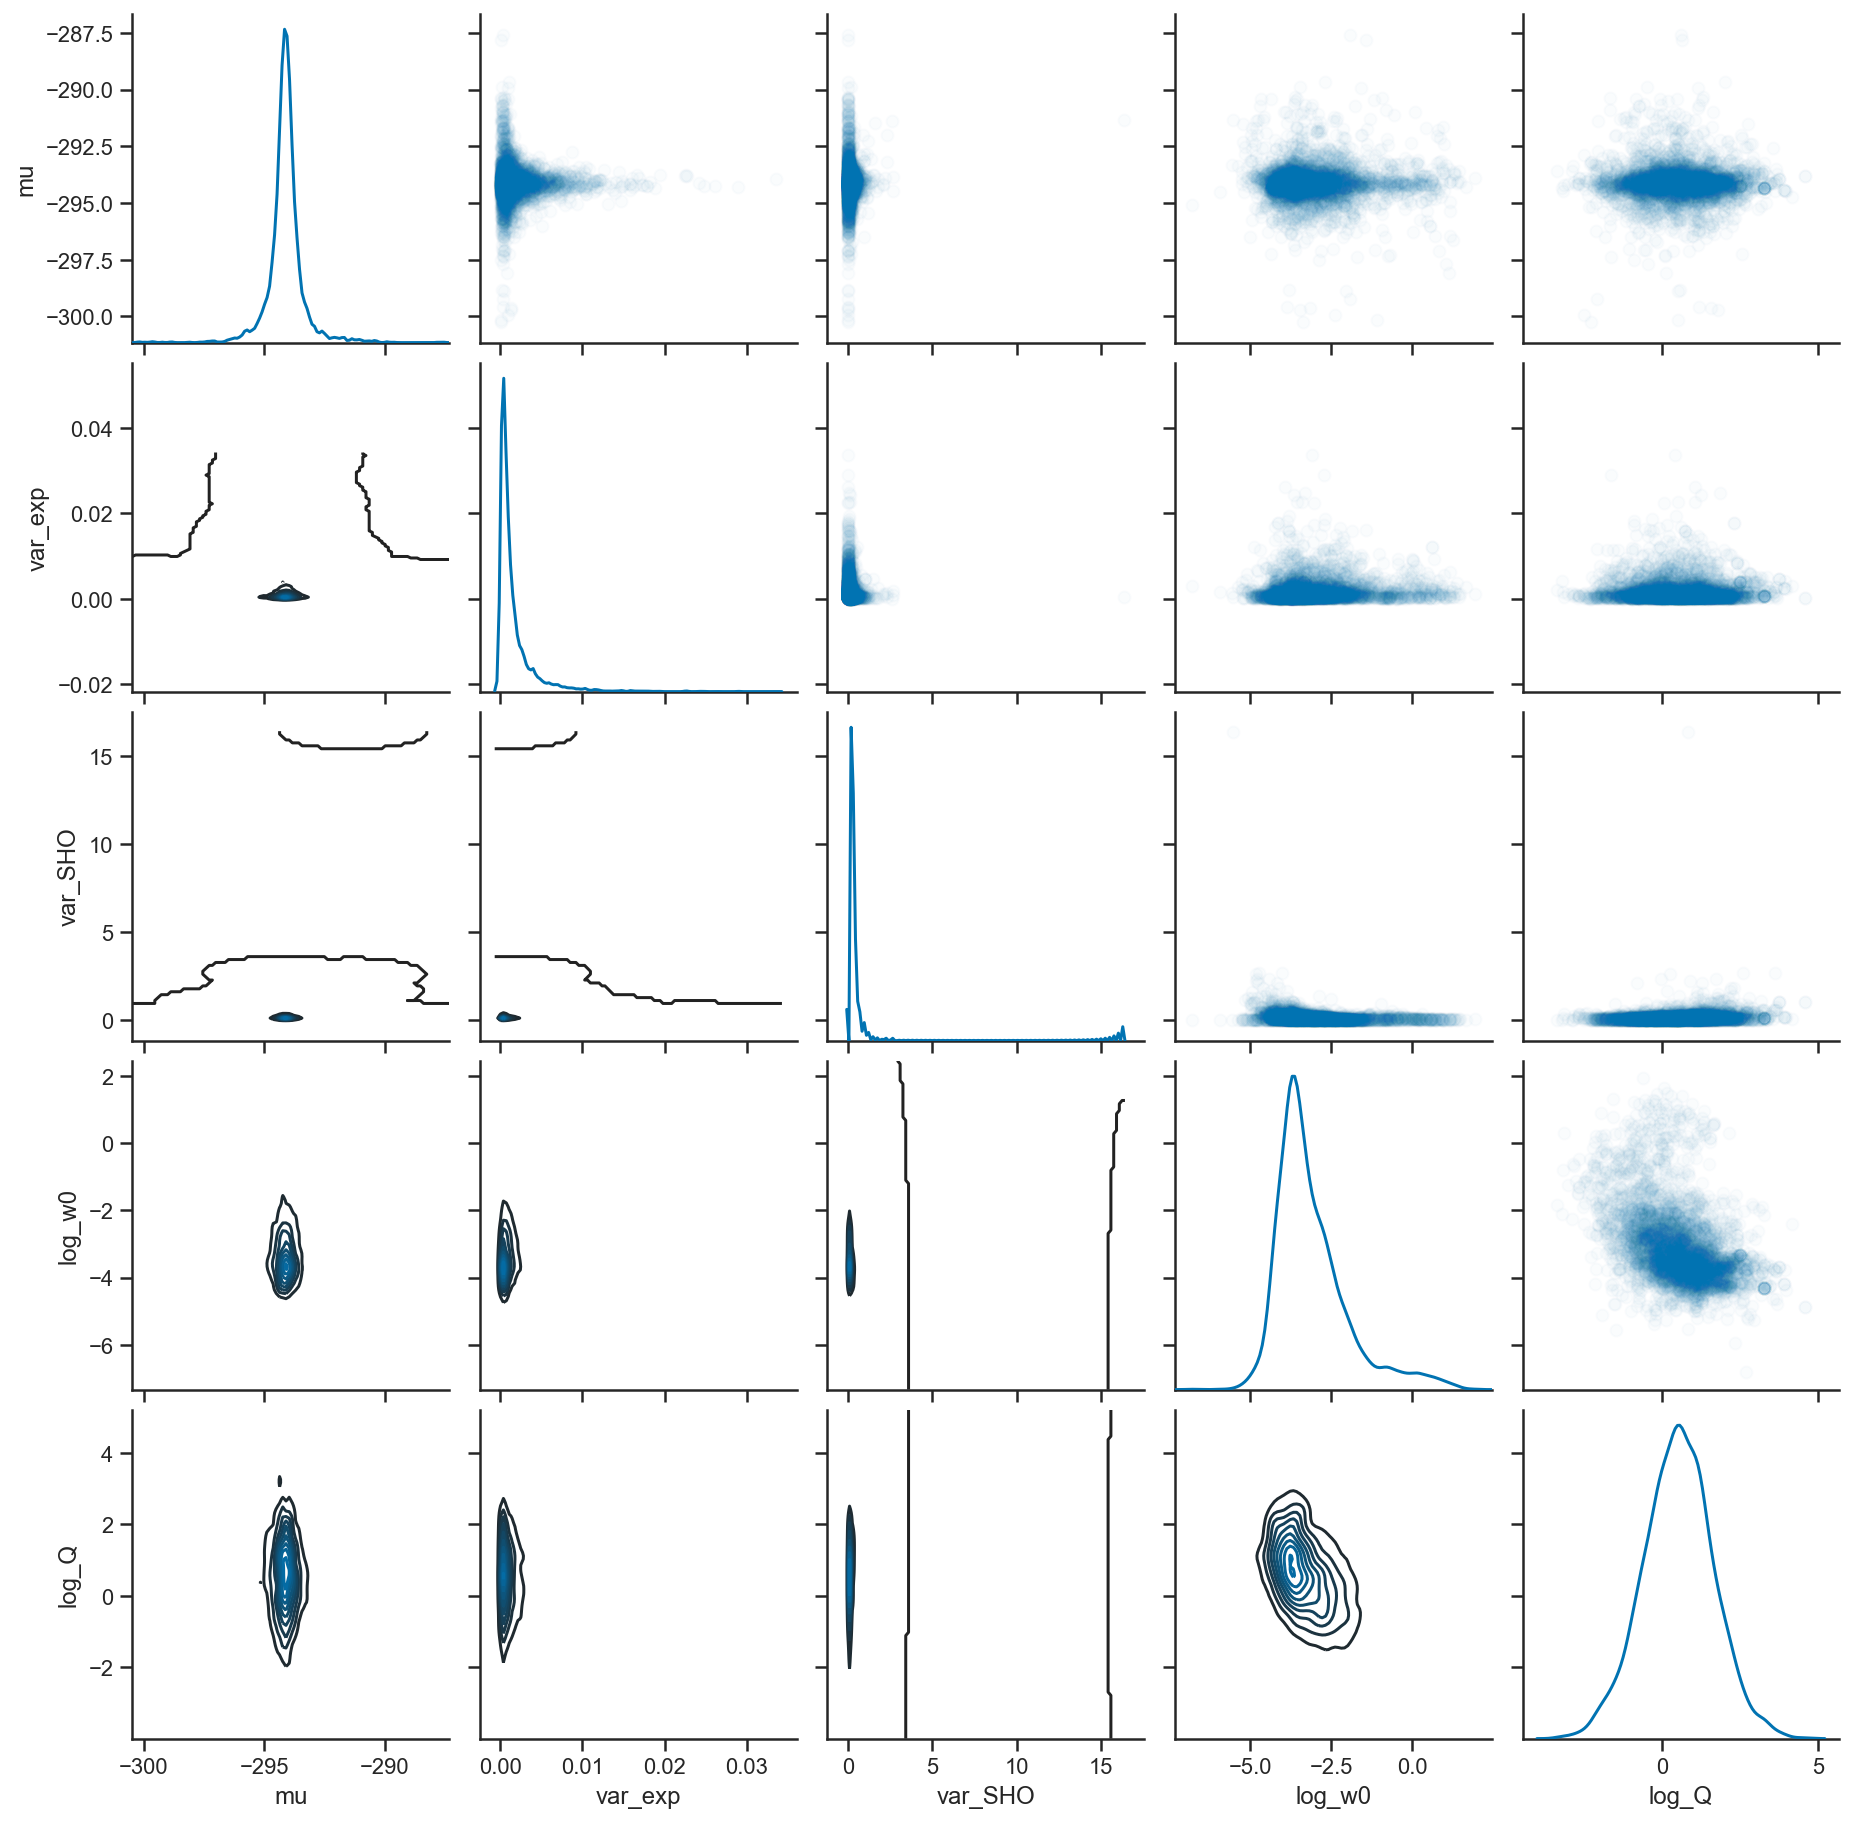

In [15]:
df = pm.trace_to_dataframe(trace)
g = sns.PairGrid(df, diag_sharey=False, vars=['mu', 'var_exp', 'var_SHO', 'log_w0', 'log_Q'])

g.map_diag(sns.kdeplot)
g.map_upper(scatter, alpha=0.02)
g.map_lower(sns.kdeplot)

In [16]:
Nt = 1024
tpred = linspace(d['JD'].min(), d['JD'].max(), Nt)

In [17]:
Np = 50
pred_mu = empty((Np, Nt))
pred_var = empty((Np, Nt))
with model:
    pred = gp.predict(tpred, return_var=True)
    for i, sample in enumerate(xo.get_samples_from_trace(trace, size=Np)):
        pred_mu[i], pred_var[i] = xo.eval_in_model(pred, sample)

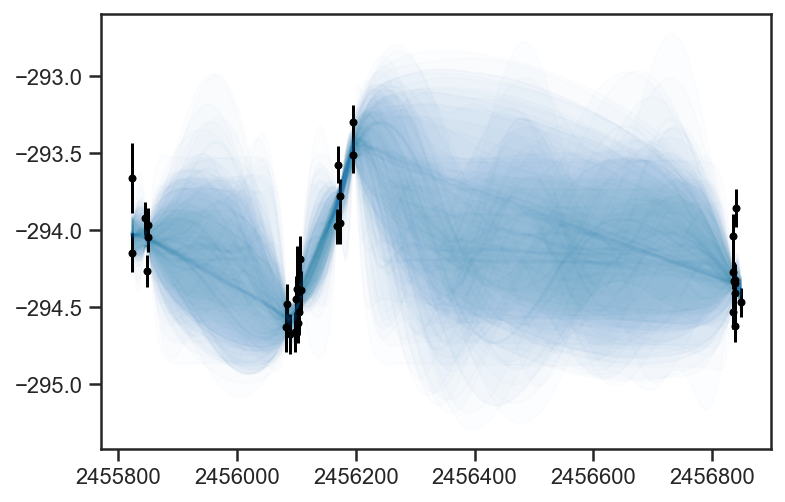

In [18]:
errorbar(d['JD'], d['VHELIO'], d['VRELERR'], fmt='.', color='k')
for i in range(Np):
    plot(tpred, pred_mu[i], color=sns.color_palette()[0], alpha=0.02)
    fill_between(tpred, pred_mu[i]+sqrt(pred_var[i]), pred_mu[i]-sqrt(pred_var[i]), color=sns.color_palette()[0], alpha=0.01)

In [19]:
No = 1024
omegas = logspace(log10(nugran_est/100.0), log10(numax_est*100.0), No)
psd = empty((Np, No))
with model:
    p = kernel.psd(omegas)
    for i, sample in enumerate(xo.get_samples_from_trace(trace, size=Np)):
        psd[i] = xo.eval_in_model(p, sample)

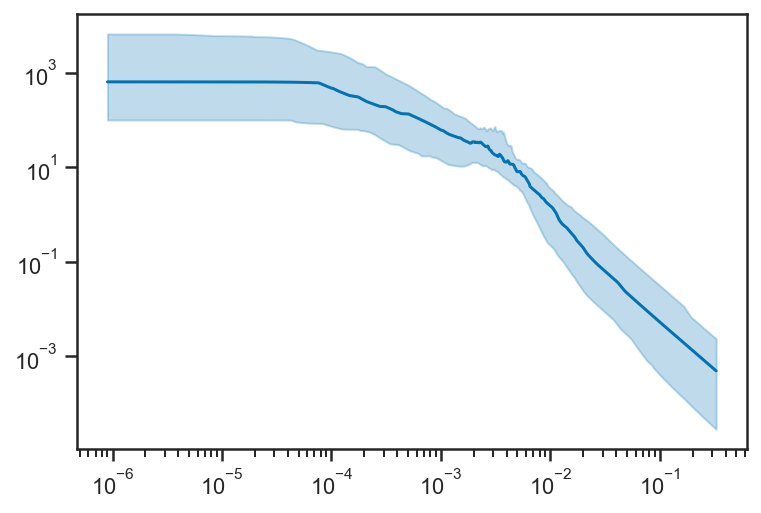

In [20]:
loglog(omegas/(2*pi), 2*pi*median(psd, axis=0))
fill_between(omegas/(2*pi), 2*pi*percentile(psd, 84, axis=0), 2*pi*percentile(psd, 16, axis=0), color=sns.color_palette()[0], alpha=0.25)

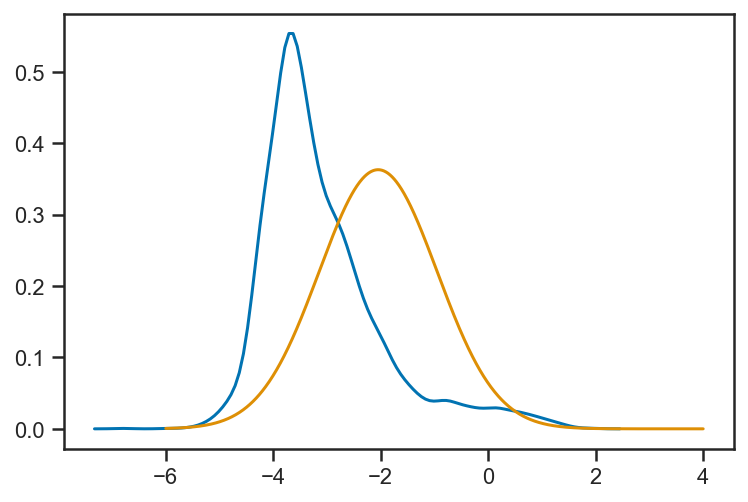

In [21]:
sns.kdeplot(trace['log_w0'])
xs = linspace(-6, 4, 1024)
plot(xs, ss.norm(loc=log(w0_est), scale=log(3)).pdf(xs))

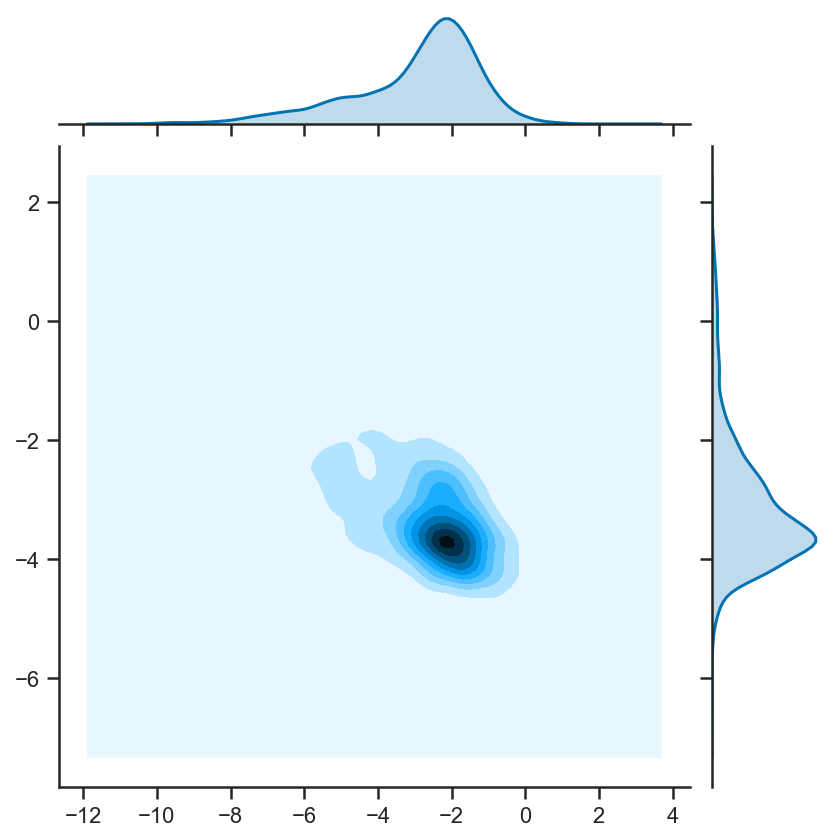

In [25]:
sns.jointplot(log(trace['var_SHO']), trace['log_w0'], kind='kde')

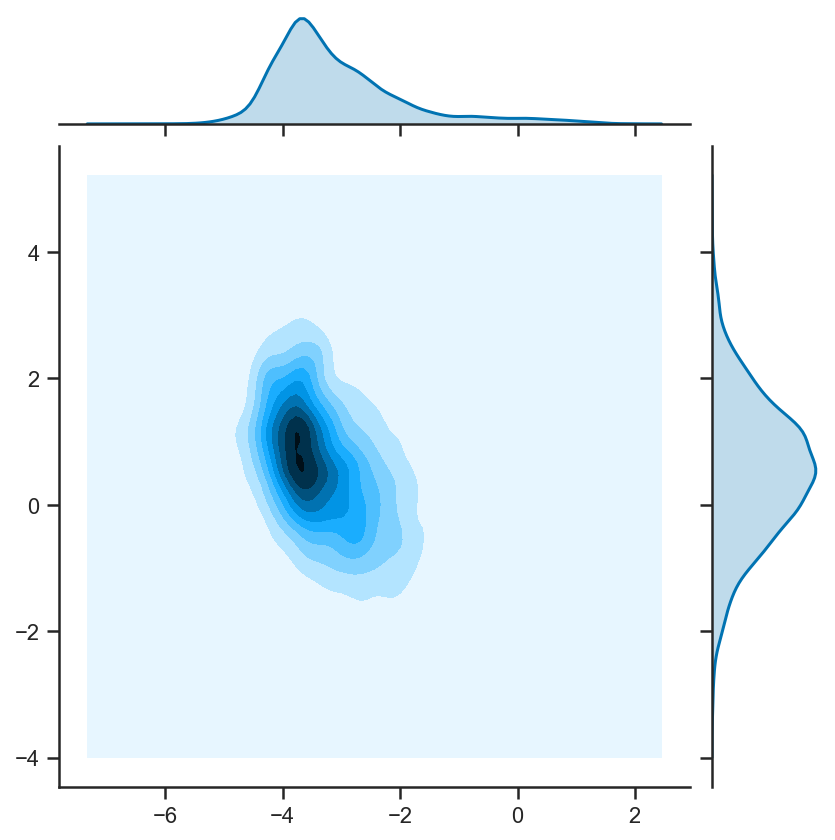

In [26]:
sns.jointplot(trace['log_w0'], trace['log_Q'], kind='kde')

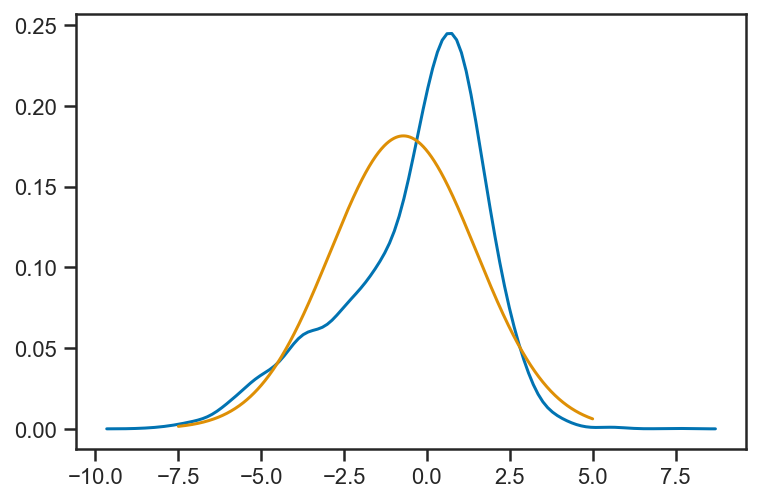

In [27]:
sns.kdeplot(trace['log_S0'])
xs = linspace(-7.5, 5, 1024)
plot(xs, ss.norm(loc=log(S0_est), scale=2*log(3)).pdf(xs))